In [1]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("Dataset/DoS_window_features.csv")

# Primeras filas
print("=== Primeras filas ===")
print(df.head())

# Información general
print("\n=== Info del dataset ===")
print(df.info())

# Valores nulos
print("\n=== Valores nulos por columna ===")
print(df.isnull().sum())

# Estadísticas básicas (solo numéricas)
print("\n=== Estadísticas descriptivas ===")
print(df.describe())

# Distribución de la etiqueta (si existe columna 'label' o similar)
if 'label' in df.columns:
    print("\n=== Distribución de la variable target (label) ===")
    print(df['label'].value_counts())

=== Primeras filas ===
   window_id    start_time      end_time  total_packets  total_bytes  \
0          0  1.698376e+09  1.698376e+09           2756     502668.0   
1          1  1.698376e+09  1.698376e+09           2221     430794.0   
2          2  1.698376e+09  1.698376e+09           4925     820389.0   
3          3  1.698376e+09  1.698376e+09           3727     626560.0   
4          4  1.698376e+09  1.698376e+09           2945     516173.0   

   avg_packet_size  avg_payload_size  packet_rate  small_packet_ratio  \
0       182.390421        114.116110       5512.0            0.730044   
1       193.963980        125.642503       4442.0            0.704638   
2       166.576447         98.696244       9850.0            0.766904   
3       168.113764        100.196941       7454.0            0.764422   
4       175.270968        107.217317       5890.0            0.750085   

   syn_count  ack_count  fin_count  label  
0        749       2007          0      1  
1        640     

✅ Mejores hiperparámetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

=== Reporte de clasificación en VALIDATION ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00       109

    accuracy                           1.00       317
   macro avg       1.00      1.00      1.00       317
weighted avg       1.00      1.00      1.00       317



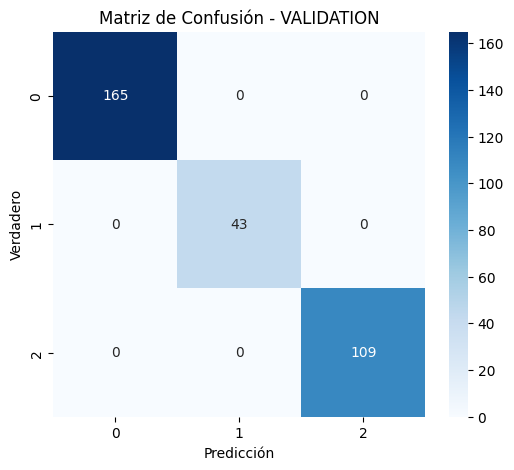

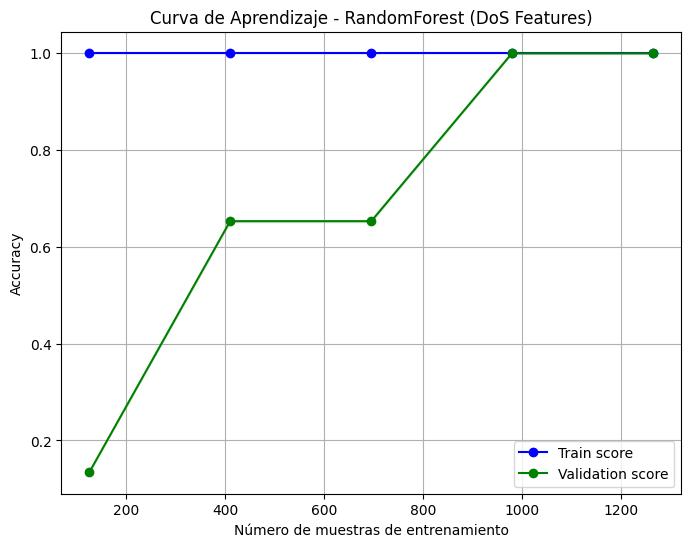


Scores finales en VALIDATION:
Accuracy: 1.000
F1-score (macro): 1.000
F1-score (weighted): 1.000
Accuracy promedio CV: 0.999 ± 0.001


In [ ]:
# train_dos_features.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ==============================
# Cargar dataset
# ==============================
df = pd.read_csv("Dataset/DoS_window_features.csv")

# ==============================
# Separar features y etiqueta
# ==============================
X = df.drop(columns=["window_id", "start_time", "end_time", "label"])
y = df["label"]

# ==============================
# División Train (60%), Test (20%), Validation (20%)
# ==============================
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Resultado: ~60% train, 20% test, 20% validation

# ==============================
# Ajuste de hiperparámetros con GridSearchCV
# ==============================
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Mejores hiperparámetros encontrados: {grid.best_params_}")

# ==============================
# Evaluación final en VALIDATION
# ==============================
best_clf = grid.best_estimator_
y_val_pred = best_clf.predict(X_val)

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION")
plt.show()

# ==============================
# Curva de aprendizaje
# ==============================
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y, cv=cv_outer, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title("Curva de Aprendizaje - RandomForest (DoS Features)")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================
# Scores finales en VALIDATION
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")

# ==============================
# Validación cruzada estratificada completa
# ==============================
cv_scores = cross_val_score(best_clf, X, y, cv=cv_outer, scoring='accuracy')
print(f"Accuracy promedio CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
